<a href="https://colab.research.google.com/github/antonium85/stock-trading-analysis/blob/main/stock_sma100vs200_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 3.8 MB/s 
     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 112 kB 54.8 MB/s 
     |████████████████████████████████| 127 kB 45.4 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=964e4e38fb66d4d41319c59e6a51a721c34ee57c00519e04c7eb42e570138d2d
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=78be2f288d57525c2be25be0583ca0a963eb02ea66a99a5d4da6404f8daca104
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=d3a9dd630758437f9b7d27e199171f5a36bdafaedc0674d99f837

In [3]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=870aedab6f8b0a35fa8fa195c496a9c9b48069993633d2c6da5abc1332ca14c1
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [4]:
import pandas as pd
import ta
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
import time

In [5]:
def get_historical_datas(ticker, interval):
  if interval == '1d':
    end_date = datetime.today()
  elif interval == '1wk':
    end_date = datetime.today() #- timedelta(1)
  start_date = end_date - timedelta(365*10)

  #print("End date = ", end_date.strftime('%d-%m-%Y'))
  #print("Start date = ", start_date.strftime('%d-%m-%Y'))

  # replace ^FCHI (CAC40) by what you want AMZN, GOOG, META ...
  output = get_data(ticker, start_date=start_date.strftime('%d/%m/%Y'), end_date=end_date.strftime('%d/%m/%Y'), index_as_date = True, interval=interval)

  #del(output)
  output['close'] = pd.to_numeric(output['close'])
  output['high'] = pd.to_numeric(output['high'])
  output['low'] = pd.to_numeric(output['low'])
  output['open'] = pd.to_numeric(output['open'])

  output['SMA25'] = ta.trend.sma_indicator(output['close'], 25)
  output['SMA50'] = ta.trend.sma_indicator(output['close'], 50)
  output['SMA100'] = ta.trend.sma_indicator(output['close'], 100)
  output['SMA99'] = ta.trend.sma_indicator(output['close'], 99)
  output['SMA200'] = ta.trend.sma_indicator(output['close'], 200)

  return output

In [6]:
#print("End date = ", end_date.strftime('%d-%m-%Y'))
#print("Start date = ", start_date.strftime('%d-%m-%Y'))

ticker_list = ["RNO.PA","AIR.PA","WLN.PA","TTE.PA","CDI.PA","MC.PA","OR.PA","EN.PA","SGO.PA","VIE.PA","UBI.PA","BNP.PA","CS.PA","BN.PA","GLE.PA","ACA.PA","ML.PA","SAN.PA","DG.PA","AI.PA","ALO.PA","CA.PA","FDJ.PA"] # FR tickers

historical_datas = {}
weekly_historical_datas = {}
for ticker in ticker_list:
  print(ticker)
  
  historical_datas[ticker] = get_historical_datas(ticker, '1d')
  weekly_historical_datas[ticker] = get_historical_datas(ticker, '1wk')

RNO.PA
AIR.PA
WLN.PA
TTE.PA
CDI.PA
MC.PA
OR.PA
EN.PA
SGO.PA
VIE.PA
UBI.PA
BNP.PA
CS.PA
BN.PA
GLE.PA
ACA.PA
ML.PA
SAN.PA
DG.PA
AI.PA
ALO.PA
CA.PA
FDJ.PA


# SMA Trading Algo
*   Cross SMA50 vs SMA100 : work well for TSLA, NFLX, PYPL
*   Cross SMA100 vs SMA200 : work well for WLN.PA, CDI.PA

In [7]:
dt = pd.DataFrame(columns = ['last action', 'date', 'traded price','actual price','wallet','pnl'])
result = dict()
lastAction=''
lastIndex = ''
lastPrice = ''
for ticker in ticker_list:
  usd = 1000
  share = 0

  df = historical_datas[ticker].copy()
  for index, row in df.iterrows():
    if row['SMA100'] > row['SMA200'] and usd > 10:
      share = usd / df['close'][index] 
      usd = 0
      
      lastIndex = index
      lastAction = 'buy'
      lastPrice = row['close']

    if row['SMA100'] < row['SMA200'] and share > 1:
      usd = share * df['close'][index]
      share = 0
      
      lastIndex = index
      lastAction = 'sell'
      lastPrice = row['close']

  finalResult = usd + share * df['close'].iloc[-1]
  result[ticker] = finalResult
  pnl = (finalResult - 1000)/1000 * 100

  myrow = pd.DataFrame({'last action':lastAction,'date':lastIndex,'traded price':lastPrice,'actual price':df['close'].iloc[-1],'wallet':finalResult,'pnl':pnl},index=[ticker])
  dt = pd.concat([dt,myrow])
  #print("Final result for ",ticker,' : ',finalResult,'$')
  #print('Ticker ',ticker,' last action ',lastAction,' date :',lastIndex,' price : ',lastPrice)

dt.sort_values(by="pnl",ascending=False)

,last action,date,traded price,actual price,wallet,pnl
UBI.PA,sell,2022-09-14,35.450001,26.709999,3109.902597,210.990260
CDI.PA,buy,2022-10-20,622.000000,617.000000,3004.588500,200.458850
WLN.PA,buy,2022-10-21,44.689999,44.689999,2482.062959,148.206296
OR.PA,sell,2022-03-31,363.850006,310.100006,2020.288540,102.028854
VIE.PA,sell,2022-06-01,25.920000,21.600000,1849.577795,84.957779
MC.PA,sell,2022-05-02,606.599976,631.500000,1699.202653,69.920265
AI.PA,sell,2022-08-30,127.599998,122.000000,1410.414424,41.041442
FDJ.PA,sell,2021-12-08,39.189999,31.620001,1272.402584,27.240258
RNO.PA,buy,2022-10-14,30.745001,32.759998,1189.168103,18.916810
DG.PA,sell,2022-06-29,86.519997,86.139999,1143.285099,14.328510


Last price :  617.0
SMA100[-1] =  610.365
SMA200[-1] =  609.4725


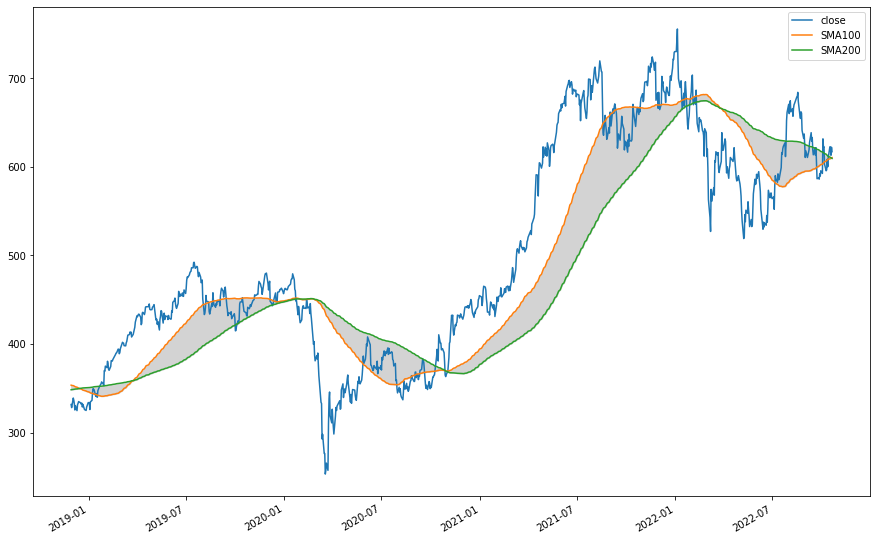

In [8]:
import matplotlib

ticker_test = 'CDI.PA'

print('Last price : ',historical_datas[ticker_test]['close'].iloc[-1])
print('SMA100[-1] = ',historical_datas[ticker_test]['SMA100'].iloc[-1])
print('SMA200[-1] = ',historical_datas[ticker_test]['SMA200'].iloc[-1])

#df[['close','SSA','SSB']].iloc[-600:].plot(figsize=(20,10))
tmp = historical_datas[ticker_test][['close','SMA100','SMA200']].tail(1000)
a1 = tmp.plot(figsize=(15,10))
a1.fill_between(tmp.index, tmp.SMA100, tmp.SMA200,color='lightgrey')